# Title: Google Play App Store Sentiment Analysis of Customer Reviews

### Data Source
- Kaggle: https://www.kaggle.com/lava18/google-play-store-apps

### Abstract
Each word in the lexicon has scores for:
- polarity: negative vs. positive    (-1.0 => +1.0)
- subjectivity: objective vs. subjective (+0.0 => +1.0)

### Import Libraries

In [204]:
## Import Libraries
import pandas as pd
import numpy as np
import regex as re
import spacy
import en_core_web_sm
from string import punctuation
import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

### Load data

In [205]:
file = 'DATA/googleplaystore_user_reviews.csv'
df = pd.read_csv(file)

### Data wrangling

In [206]:
df.shape

(64295, 5)

In [207]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [208]:
df.App.value_counts()

Bowmasters                                           320
Angry Birds Classic                                  320
CBS Sports App - Scores, News, Stats & Watch Live    320
8 Ball Pool                                          300
Helix Jump                                           300
                                                    ... 
Dresses Ideas & Fashions +3000                        31
Detector de Radares Gratis                            31
Easy Healthy Recipes                                  31
Drawing Clothes Fashion Ideas                         30
Easy Hair Style Design                                30
Name: App, Length: 1074, dtype: int64

- the dataset represents 1074 Google Play Mobile Apps with Reviews ranging from 30 - 320 per app

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [210]:
df.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [211]:
# drop rows with null or nan values
df = df.dropna()

In [212]:
# change names of columns
df.columns = ['app', 'review', 'sentiment', 'polarity', 'subjectivity']

In [213]:
df.head()

,app,review,sentiment,polarity,subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [214]:
# Remove app column
df.drop(['app', 'subjectivity'], axis='columns', inplace=True)

In [215]:
df

,review,sentiment,polarity
0,I like eat delicious food. That's I'm cooking ...,Positive,1.000000
1,This help eating healthy exercise regular basis,Positive,0.250000
3,Works great especially going grocery store,Positive,0.400000
4,Best idea us,Positive,1.000000
5,Best way,Positive,1.000000
...,...,...,...
64222,Most ads older many agents ..not much owner po...,Positive,0.173333
64223,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000
64226,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500
64227,I property business got link SMS happy perform...,Positive,0.800000


### Staging for text cleaning

In [216]:
nlp = en_core_web_sm.load()

### Prepare the text

This stage involves all the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international charaters
- handle symbols
- handle metadata and embeded information
- handle repetitions (such multiple spaces or newlines)

In [217]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)
    return text

In [218]:
%%time
text_cleaned = []
for text in df.review:
    text_cleaned.append(clean_text(text))

Wall time: 497 ms


In [219]:
df.review = text_cleaned

### Work the text
Concern with the meaning and the substance of the content to extract actual information.

In [220]:
def convert_text(text):
    '''
    Remove StopWords, and Lemmatize etc.
    '''
    # remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # remove anything that is not alphanumeric or underscore
    doc = nlp(text)
    converted_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return converted_text

In [221]:
%%time
df['short'] = df.review.apply(convert_text)

Wall time: 3min 28s


In [222]:
df.sample(10)

,review,sentiment,polarity,short
56507,I never want share photos device. I never want...,Positive,0.166335,want share photo device want Google organisati...
62037,I really like game. I uninstalled make room ph...,Positive,0.075000,like game uninstalle room phone reinstall lose...
4045,Using Google pixel 2 I put email freezes. It l...,Neutral,0.000000,Google pixel 2 email freeze let keyboard input...
11917,Most unfortunate great concept ruined bad prog...,Positive,0.026786,unfortunate great concept ruin bad programming...
42069,I harassed accused stealing art whole time I a...,Positive,0.250000,harass accuse steal art time app trash
53003,It said meet gay sugar babies without meaningl...,Negative,-0.256667,say meet gay sugar baby meaningless conversati...
25360,Really great I love,Positive,0.650000,great love
30845,Convfefe,Neutral,0.000000,convfefe
1794,I think Lovely xxx,Positive,0.500000,think Lovely xxx
44939,Please 5e27e,Neutral,0.000000,5e27e


### Perform basic EDA

In [223]:
# this shows the aggregate distinct values of the target variable can be multinomial
df.sentiment.value_counts()

Positive    23998
Negative     8271
Neutral      5158
Name: sentiment, dtype: int64

- Fortunately the dataset is large or there won't be enough training examples of all categories to fit the model

In [224]:
df_neg = df.loc[(df.sentiment == 'Negative')]

In [225]:
text_neg = ''
for text in df_neg.review:
    text_neg += text + ' '

In [226]:
cloud_neg = WordCloud().generate(str(text_neg))

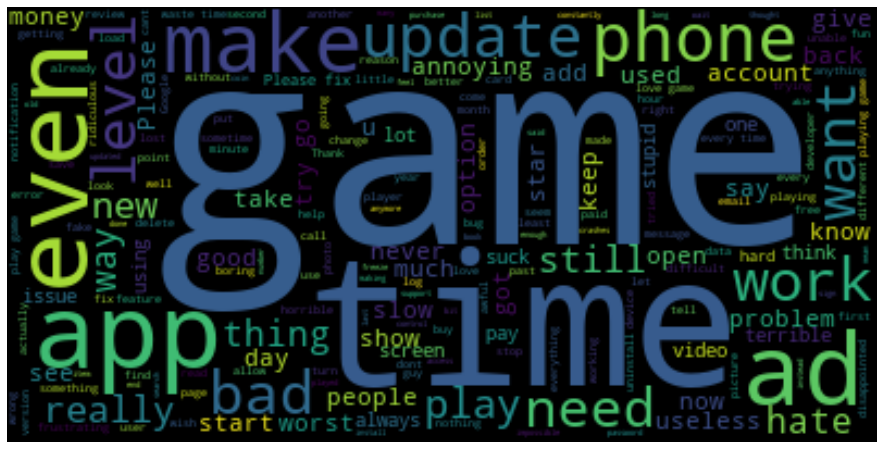

In [227]:
plt.figure(figsize=(16,8))
plt.imshow(cloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

In [228]:
df_neut = df.loc[(df.sentiment == 'Neutral')]

In [229]:
text_neut = ''
for text in df_neut.review:
    text_neut += text + ' '

In [230]:
cloud_neut = WordCloud().generate(str(text_neut))

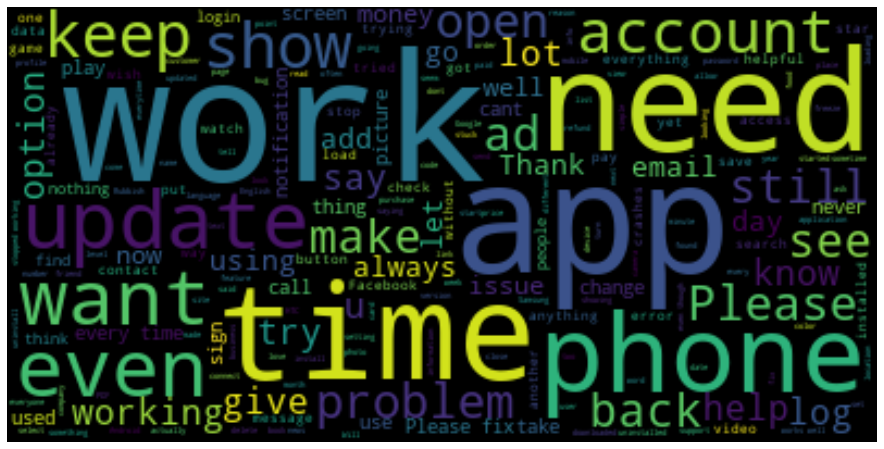

In [231]:
plt.figure(figsize=(16,8))
plt.imshow(cloud_neut, interpolation='bilinear')
plt.axis("off")
plt.show()

In [232]:
df_pos = df.loc[(df.sentiment == 'Positive')]

In [233]:
%%time
text_pos = ''
for text in df_pos.review:
    text_pos += text + ' '

Wall time: 851 ms


In [234]:
cloud_pos = WordCloud().generate(str(text_pos))

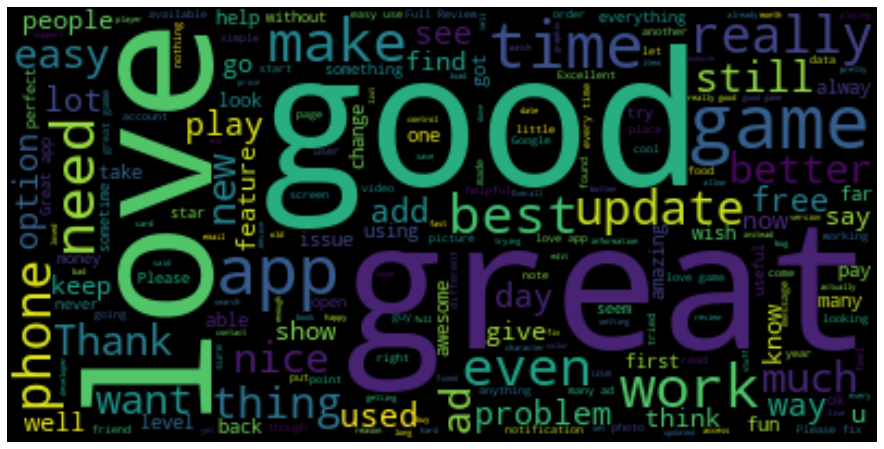

In [235]:
plt.figure(figsize=(16,8))
plt.imshow(cloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

In [236]:
df.dtypes

review        object
sentiment     object
polarity     float64
short         object
dtype: object

#### Map code to sentiment

Should we keep the neutral class in our data set since it only is relevent when polarity = 0?

From Wikipedia: "Even though in most statistical classification methods, the neutral class is ignored under the assumption that neutral texts lie near the boundary of the binary classifier, several researchers suggest that, as in every polarity problem, three categories must be identified. Moreover, it can be proven that specific classifiers such as the Max Entropy and SVMs can benefit from the introduction of a neutral class and improve the overall accuracy of the classification."

Source: https://en.wikipedia.org/wiki/Sentiment_analysis

In [237]:
codes = {'Negative':-1, 'Neutral':0, 'Positive':1}

In [238]:
df['sentiment'] = df.sentiment.map(codes)

In [239]:
df.dtypes

review        object
sentiment      int64
polarity     float64
short         object
dtype: object

#### Describe distribution

In [240]:
df.describe()

,sentiment,polarity
count,37427.000000,37427.000000
mean,0.420205,0.182171
std,0.828029,0.351318
min,-1.000000,-1.000000
25%,0.000000,0.000000
50%,1.000000,0.150000
75%,1.000000,0.400000
max,1.000000,1.000000


- Polarity is simply the scalar version of sentiment, and hence should only be included in the model to estimate a regressor and of a classifier
- The collinearity between sentiment and polarity is further reinforced by the positive skewness of the boxplots, where outliers towards the negative side of polarity are many.
- Subjectivity denotes the objectivity and subjectivity of text respectively
- Dataset need not be scaled as original values should be preserved to represent the nominal scales

### Selecting features and splitting data

In [241]:
# Features and Labels
X = df['short']
y = df['sentiment'] 

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Feature Engineering

#### Count Vectors as features

In [242]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

#### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [243]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
Wall time: 908 ms


In [244]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
Wall time: 3.36 s


In [245]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')
Wall time: 7.06 s


### Modelling for multiclass prediction accuracy using different features

In [246]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    accuracy = accuracy_score(predictions, y_test)
    
    return accuracy

In [247]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

#### Logistic Regression

In [248]:
# create classifiers using GridSearchCV
params_log = {'penalty': ['l1','l2'], 
             'C': np.logspace(-4, 4, 10)}
clf_log = GridSearchCV(LogisticRegression(solver = 'lbfgs', random_state=42, multi_class='multinomial'), params_log, cv=5)

In [249]:
%%time
clf_log.fit(X_train_count, y_train)

Wall time: 52 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [250]:
clf_log.best_estimator_

LogisticRegression(C=2.782559402207126, multi_class='multinomial',
                   random_state=42)

In [251]:
%%time
# Logistic Regression on Count Vectors
accuracy1  = train_model(clf_log.best_estimator_, X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.8973

Wall time: 1.75 s


In [252]:
%%time
# Logistic Regression on Count Vectors
accuracy2 = train_model(clf_log.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.8973

Wall time: 1.2 s


In [253]:
%%time
# Logistic Regression on Count Vectors
accuracy3 = train_model(clf_log.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.8973

Wall time: 932 ms


In [254]:
%%time
# Logistic Regression on Count Vectors
accuracy4 = train_model(clf_log.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.8973

Wall time: 3.61 s


In [255]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Support Vector Classifier

In [260]:
clf_SVC = LinearSVC(random_state=42)

In [261]:
%%time
clf_SVC.fit(X_train_count, y_train)

Wall time: 2.41 s


LinearSVC(random_state=42)

In [263]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(clf_SVC, X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.8967

Wall time: 2.71 s


In [267]:
%%time
# Support Vector Machine on Count Vectors
accuracy2 = train_model(clf_SVC, X_train_tfidf, y_train, X_test_tfidf)
print('SVM, Count Vectors    : %.4f\n' % accuracy2)

SVM, Count Vectors    : 0.8922

Wall time: 197 ms


In [268]:
%%time
# Support Vector Machine on Count Vectors
accuracy3 = train_model(clf_SVC, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, Count Vectors    : %.4f\n' % accuracy3)

SVM, Count Vectors    : 0.7040

Wall time: 169 ms


In [269]:
%%time
# Support Vector Machine on Count Vectors
accuracy4 = train_model(clf_SVC, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVM, Count Vectors    : %.4f\n' % accuracy4)

SVM, Count Vectors    : 0.8603

Wall time: 1.52 s


In [270]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Stochastic Gradient Descent Classifier

In [271]:
params_SGD = {'loss': ['hinge', 'log', 'modified_huber'],
              'penalty': ['l1','l2'], 
              'alpha': np.linspace(0.1, 1, 10)}
clf_SGD = GridSearchCV(SGDClassifier(random_state=42), params_SGD, cv=5)

In [62]:
%%time
clf_SGD.fit(X_train_count, y_train)

Wall time: 31.1 s


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'loss': ['hinge', 'log', 'modified_huber'],
                         'penalty': ['l1', 'l2']})

In [63]:
clf_SGD.best_estimator_

SGDClassifier(alpha=0.1, loss='modified_huber', random_state=42)

In [64]:
%%time
# SGD on Count Vectors
accuracy1 = train_model(clf_SGD.best_estimator_, X_train_count, y_train, X_test_count)
print('SGD, Count Vectors    : %.4f\n' % accuracy1)

SGD, Count Vectors    : 0.7084

Wall time: 87 ms


In [65]:
%%time
# SGD on Count Vectors
accuracy2 = train_model(clf_SGD.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('SGD, Count Vectors    : %.4f\n' % accuracy2)

SGD, Count Vectors    : 0.6391

Wall time: 76 ms


In [66]:
%%time
# SGD on Count Vectors
accuracy3 = train_model(clf_SGD.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SGD, Count Vectors    : %.4f\n' % accuracy3)

SGD, Count Vectors    : 0.6391

Wall time: 64 ms


In [67]:
%%time
# SGD on Count Vectors
accuracy4 = train_model(clf_SGD.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SGD, Count Vectors    : %.4f\n' % accuracy4)

SGD, Count Vectors    : 0.6391

Wall time: 272 ms


In [68]:
results.loc['Stochastic Gradient Descent'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Naive Bayes Classifier

In [69]:
param_NB = {'alpha': np.linspace(0.1, 1, 10)}
clf_NB = GridSearchCV(MultinomialNB(), param_NB, cv=5)

In [70]:
%%time
clf_NB.fit(X_train_count, y_train)

Wall time: 496 ms


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [71]:
clf_NB.best_estimator_

MultinomialNB(alpha=0.5)

In [72]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(clf_NB.best_estimator_, X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.7805

Wall time: 7 ms


In [73]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(clf_NB.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)

NB, WordLevel TF-IDF : 0.7467

Wall time: 7 ms


In [74]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_NB.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.7018

Wall time: 6 ms


In [75]:
%%time
# # Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(clf_NB.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('NB, CharLevel Vectors: %.4f\n' % accuracy4)

NB, CharLevel Vectors: 0.7279

Wall time: 27 ms


In [76]:
results.loc['Naive Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### K Nearest Neighbours

In [77]:
params_KNN = {'metric': ['euclidean', 'manhattan'],
 'n_neighbors': np.arange(1, 16)}
clf_KNN = GridSearchCV(KNeighborsClassifier(), params_KNN, cv=5)

In [78]:
%%time
clf_KNN.fit(X_train_count, y_train)

Wall time: 8min 32s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [79]:
clf_KNN.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [80]:
%%time
# KNN on Count Vectors
accuracy1 = train_model(clf_KNN.best_estimator_, X_train_count, y_train, X_test_count)
print('KNN, Count Vectors    : %.4f\n' % accuracy1)

KNN, Count Vectors    : 0.7837

Wall time: 4.05 s


In [81]:
%%time
# KNN on Word Level TF IDF Vectors
accuracy2 = train_model(clf_KNN.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('KNN, WordLevel TF-IDF : %.4f\n' % accuracy2)

KNN, WordLevel TF-IDF : 0.5725

Wall time: 3.96 s


In [82]:
%%time
# KNN on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_KNN.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('KNN, N-Gram Vectors   : %.4f\n' % accuracy3)

KNN, N-Gram Vectors   : 0.6961

Wall time: 1.87 s


In [83]:
%%time
# KNN on Character Level TF IDF Vectors
accuracy4 = train_model(clf_KNN.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('KNN, CharLevel Vectors: %.4f\n' % accuracy4)

KNN, CharLevel Vectors: 0.5672

Wall time: 24.8 s


In [84]:
results.loc['K-Nearest Neighbors'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Decision Trees

In [85]:
clf_dt = DecisionTreeClassifier()

In [86]:
%%time
clf_dt.fit(X_train_count, y_train)

Wall time: 4.56 s


DecisionTreeClassifier()

In [87]:
%%time
# Decision Tree on Count Vectors
accuracy1 = train_model(clf_dt, X_train_count, y_train, X_test_count)
print('DT, Count Vectors    : %.4f\n' % accuracy1)

DT, Count Vectors    : 0.8731

Wall time: 4.53 s


In [88]:
%%time
# Decision Tree on Word Level TF IDF Vectors
accuracy2 = train_model(clf_dt, X_train_tfidf, y_train, X_test_tfidf)
print('DT, WordLevel TF-IDF : %.4f\n' % accuracy2)

DT, WordLevel TF-IDF : 0.8728

Wall time: 3.47 s


In [89]:
%%time
# Decision Tree on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_dt, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('DT, N-Gram Vectors   : %.4f\n' % accuracy3)

DT, N-Gram Vectors   : 0.7128

Wall time: 4.78 s


In [90]:
%%time
# Decision Tree on Character Level TF IDF Vectors
accuracy4 = train_model(clf_dt, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('DT, CharLevel Vectors: %.4f\n' % accuracy4)

DT, CharLevel Vectors: 0.7980

Wall time: 29.6 s


In [91]:
results.loc['Decision Tree'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

#### Random Forest

In [92]:
clf_rf = RandomForestClassifier(random_state=42)

In [93]:
%%time
clf_rf.fit(X_train_count, y_train)

Wall time: 1min 13s


RandomForestClassifier(random_state=42)

In [94]:
%%time
# Random Forest on Count Vectors
accuracy1 = train_model(clf_rf, X_train_count, y_train, X_test_count)
print('RF, Count Vectors    : %.4f\n' % accuracy1)

RF, Count Vectors    : 0.8834

Wall time: 1min 14s


In [95]:
%%time
# Random Forest on Word Level TF IDF Vectors
accuracy2 = train_model(clf_rf, X_train_tfidf, y_train, X_test_tfidf)
print('RF, WordLevel TF-IDF : %.4f\n' % accuracy2)

RF, WordLevel TF-IDF : 0.8863

Wall time: 23.8 s


In [96]:
%%time
# Random Forest on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_rf, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RF, N-Gram Vectors   : %.4f\n' % accuracy3)

RF, N-Gram Vectors   : 0.7263

Wall time: 44.6 s


In [97]:
%%time
# Random Forest on Character Level TF IDF Vectors
accuracy4 = train_model(clf_rf, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('DT, CharLevel Vectors: %.4f\n' % accuracy4)

DT, CharLevel Vectors: 0.8416

Wall time: 1min 23s


In [98]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [99]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Logistic Regression,0.897275,0.889260,0.707454,0.851055
Support Vector Machine,0.896741,0.870692,0.696767,0.831285
Stochastic Gradient Descent,0.708389,0.639060,0.639060,0.639060
Naive Bayes,0.780524,0.746727,0.701843,0.727892
K-Nearest Neighbors,0.783730,0.572535,0.696099,0.567192
Decision Tree,0.873096,0.872829,0.712797,0.798023
Random Forest,0.883382,0.886321,0.726289,0.841571


### Comparing best models using ROC curve

#### Change target variable into binary class

In [272]:
df = df[df.sentiment != 0]

In [273]:
df.sentiment = df.sentiment.replace(-1, 0)

In [274]:
df.head()

,review,sentiment,polarity,short
0,I like eat delicious food. That's I'm cooking ...,1,1.00,like eat delicious food s m cook food case 10 ...
1,This help eating healthy exercise regular basis,1,0.25,help eat healthy exercise regular basis
3,Works great especially going grocery store,1,0.40,work great especially go grocery store
4,Best idea us,1,1.00,good idea
5,Best way,1,1.00,good way


In [275]:
df.shape

(32269, 4)

#### Rerun feature selection, data splitting and feature engineering

In [276]:
# Features and Labels
X = df['short']
y = df['sentiment'] 

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [277]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [278]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
Wall time: 856 ms


In [279]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
Wall time: 3.13 s


In [280]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')
Wall time: 6.49 s


### Modelling for Bernoulli prediction accuracy using different features

* The results dataframe told us what features make the best regressors/ predictors
* Here, we want to determine which models make the best predictions
* Hence, we use bag-of-words features (i.e. Count Vectorizer) not because it produces the best accuracy scores, as even TF-IDF arguably minimizes overfitting with detection of common words, but because it is sufficient for the purpose described.

In [281]:
def summary_report(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    pred_proba_ = classifier.predict_proba(feature_vector_valid)
    
    accuracy_ = accuracy_score(y_test, predictions)
    precision_ = precision_score(y_test, predictions)
    recall_ = recall_score(y_test, predictions)
    roc_auc_ = roc_auc_score(y_test, predictions)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(y_test, predictions)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, pred_proba_[:,1])
    roc_auc = auc(fpr, tpr)
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax=ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
     # ROC
    ax[1].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[1].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].legend(loc = 'lower right')

    plt.show()
    
    return (fpr, tpr, roc_auc)

#### ROC curve: Logistic Regression

In [149]:
%%time
# Retrain logistic regression model with binary target
clf_log.fit(X_train_count, y_train)

Wall time: 33.2 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

Accuracy : 0.9331 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9481 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9620 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9068                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


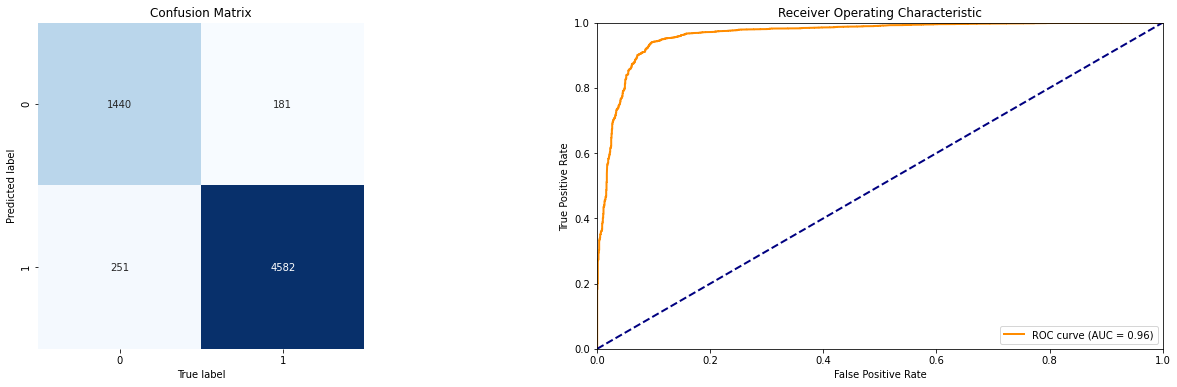

Wall time: 1.37 s


In [185]:
%%time
# Logistic Regression on Count Vectors
fpr1, tpr1, roc_auc1 = summary_report(clf_log.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: Stochastic Gradient Descent

In [115]:
%%time
# Retrain SGD model with binary target
clf_SGD.fit(X_train_count, y_train)

Wall time: 13.2 s


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'loss': ['hinge', 'log', 'modified_huber'],
                         'penalty': ['l1', 'l2']})

Accuracy : 0.8210 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8140 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9819 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6749                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


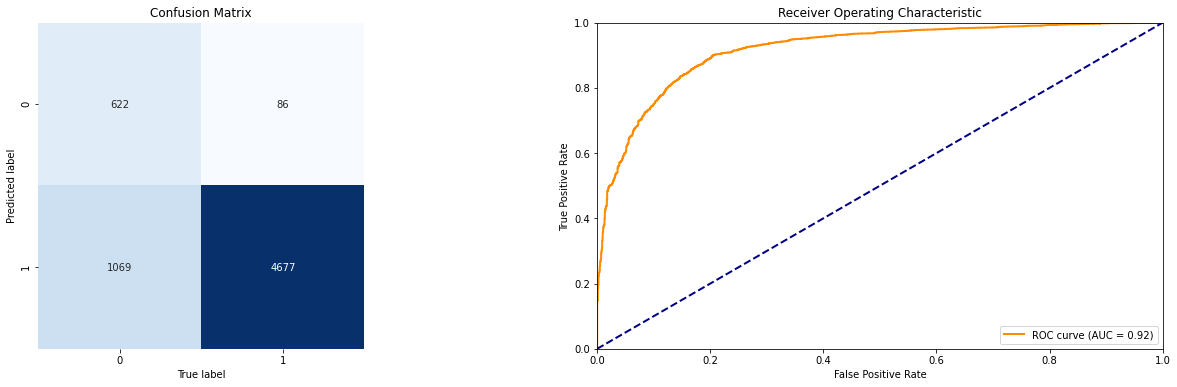

Wall time: 336 ms


In [188]:
%%time
# SGD on Count Vectors
fpr3, tpr3, roc_auc3  = summary_report(clf_SGD.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: Naive Bayes

In [117]:
%%time
# Retrain Naive Bayes model with binary target
clf_NB.fit(X_train_count, y_train)

Wall time: 401 ms


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

Accuracy : 0.8672 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9032 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9185 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8206                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


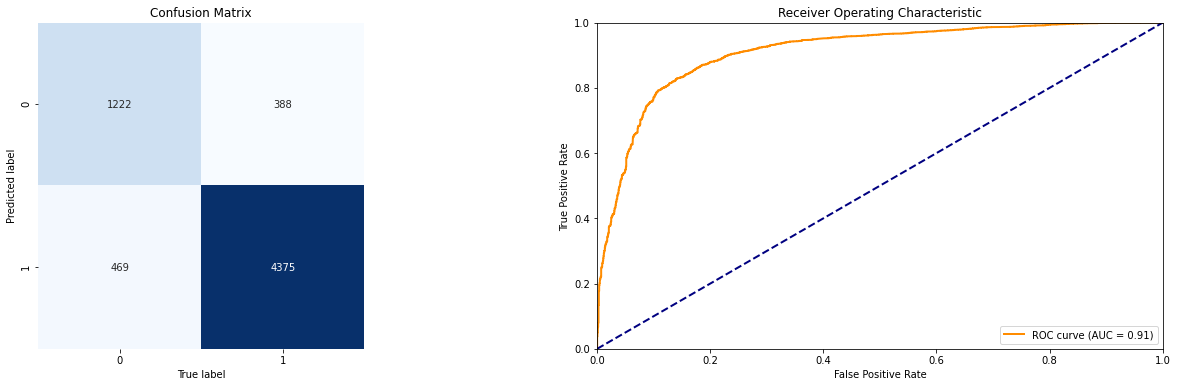

Wall time: 261 ms


In [189]:
%%time
# Naive Bayes on Count Vectors
fpr4, tpr4, roc_auc4  = summary_report(clf_NB.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: K-nearest Neighbors

In [119]:
%%time
# Retrain KNN model with binary target
clf_KNN.fit(X_train_count, y_train)

Wall time: 5min 59s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

Accuracy : 0.8703 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8876 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9437 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8036                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


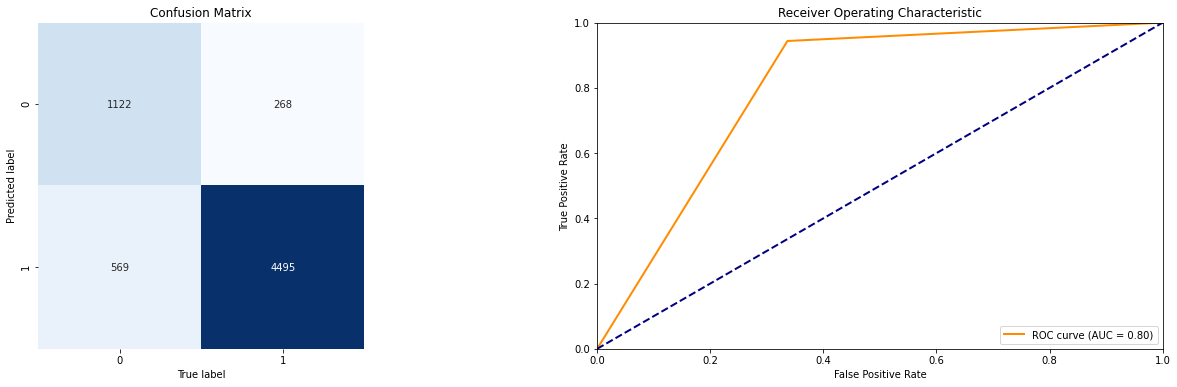

Wall time: 6.38 s


In [190]:
%%time
# KNN on Count Vectors
fpr5, tpr5, roc_auc5  = summary_report(clf_KNN.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: Decision Tree

In [121]:
%%time
# Retrain decision tree model with binary target
clf_dt.fit(X_train_count, y_train)

Wall time: 3.41 s


DecisionTreeClassifier()

Accuracy : 0.8988 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9367 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9255 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8746                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


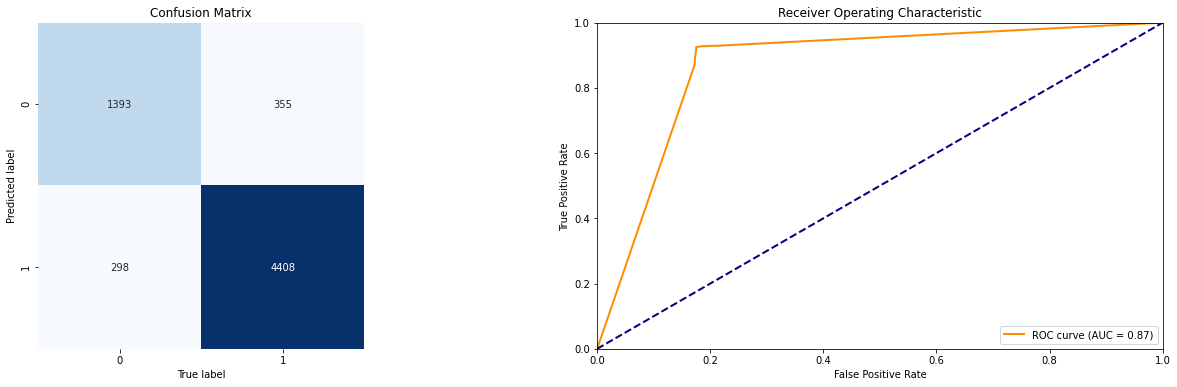

In [191]:
fpr6, tpr6, roc_auc6  = summary_report(clf_dt, X_train_count, y_train, X_test_count)

#### ROC curve: Random Forest

In [192]:
%%time
# Retrain decision tree model with binary target
clf_rf.fit(X_train_count, y_train)

Wall time: 51.9 s


RandomForestClassifier(random_state=42)

Accuracy : 0.9194 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9212 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9742 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8697                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


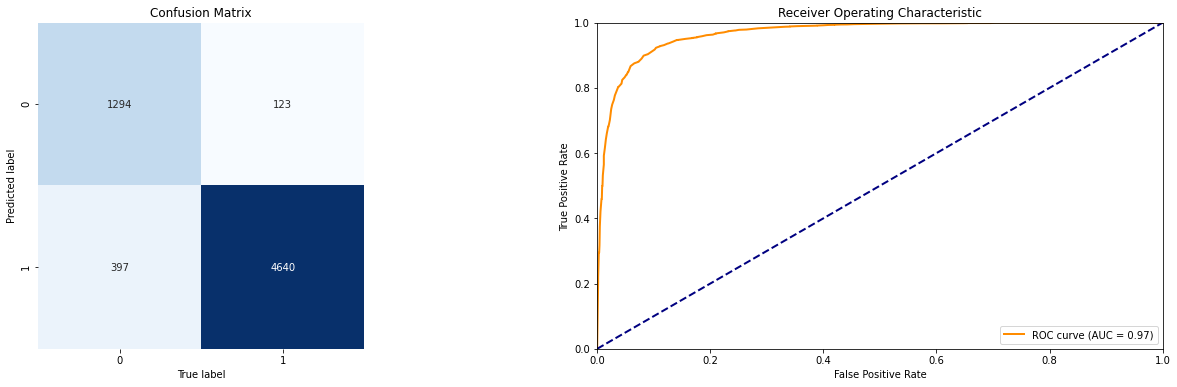

Wall time: 53 s


In [193]:
%%time
# random forests on Count Vectors
fpr7, tpr7, roc_auc7  = summary_report(clf_rf, X_train_count, y_train, X_test_count)

### ROC curve summary

In [194]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Logistic Regression,0.897275,0.889260,0.707454,0.851055
Support Vector Machine,0.896741,0.870692,0.696767,0.831285
Stochastic Gradient Descent,0.708389,0.639060,0.639060,0.639060
Naive Bayes,0.780524,0.746727,0.701843,0.727892
K-Nearest Neighbors,0.783730,0.572535,0.696099,0.567192
Decision Tree,0.873096,0.872829,0.712797,0.798023
Random Forest,0.883382,0.886321,0.726289,0.841571


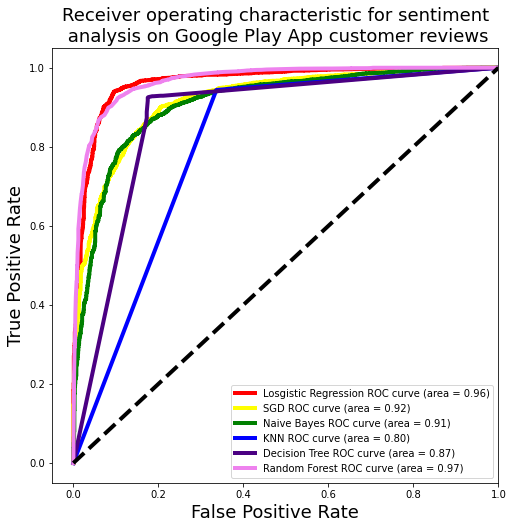

In [285]:
# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

# Plot fpr, tpr

plt.plot(fpr1, tpr1, color='red', lw=4, label = 'Losgistic Regression ROC curve (area = %0.2f)' % roc_auc1)
plt.plot(fpr3, tpr3, color='yellow', lw=4, label = 'SGD ROC curve (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='green', lw=4, label = 'Naive Bayes ROC curve (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='blue', lw=4, label = 'KNN ROC curve (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='indigo', lw=4, label = 'Decision Tree ROC curve (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='violet', lw=4, label = 'Random Forest ROC curve (area = %0.2f)' % roc_auc7)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for sentiment\n analysis on Google Play App customer reviews', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Testing the models on new data

#### Using a webscraper from Google Play API

In [1]:
from google_play_scraper import app
from print_dict import pd as prtd

In [2]:
app_ids = ['com.mobincube.ndis_provider_directory.sc_592DRC&showAllReviews=true', 'com.planready', 
            'com.mysalesforce.mycommunity.C00D7F000003E7pqUAC.A0OT7F0000004C94WAE',
            'au.com.myplanmanager&showAllReviews=true',
            'com.planready.ucq', 'com.itelasoft.PlanTracker&showAllReviews=true',
            'com.ionicframework.bettercaring45581069&showAllReviews=true',
            'com.mysalesforce.mycommunity.C00D7F000004cbJAUAY.A0OT2P000000000HWAQ&showAllReviews=true',
            'au.gov.dhs.expressplus.medicare&showAllReviews=true'
         ]

* The features extracted with Google Play API like title, score, installs, price, genre, and comments for each app are included in the logs, appended to a logs.txt file to reference the type of niche market being analysed, such that the predicted sentiment would help decide whether a certain app idea is worth investing in or not.

In [3]:
def get_dictionary(app_ids):
    '''
    params: Takes in Google Play app ids
    returns: Outputs a dictionary with comments as keys 
    '''
    dict = {}
    logs = []
    reviews = []
    for id in app_ids:
        result = app(
            id,
            lang='en', # defaults to 'en'
            country='us' # defaults to 'us'
        )
        
        for k, v in result.items():
            if k == 'title' or k == 'summary' or k == 'score' or k == 'installs' or k == 'price' or \
                k == 'genre':
                string = k + ': ' + str(v)
                logs.append(string)
        
        reviews += result['comments']
        data = {'comments': reviews}
        df = pd.DataFrame.from_dict(data)
    
    df.to_csv('DATA/new_reviews_data.csv')
    
    with open('logs.txt', 'w', encoding="utf-8") as f:
        f.write(str(logs))

    return df, logs

In [4]:
app_ids

['com.mobincube.ndis_provider_directory.sc_592DRC&showAllReviews=true',
 'com.planready',
 'com.mysalesforce.mycommunity.C00D7F000003E7pqUAC.A0OT7F0000004C94WAE',
 'au.com.myplanmanager&showAllReviews=true',
 'com.planready.ucq',
 'com.itelasoft.PlanTracker&showAllReviews=true',
 'com.ionicframework.bettercaring45581069&showAllReviews=true',
 'com.mysalesforce.mycommunity.C00D7F000004cbJAUAY.A0OT2P000000000HWAQ&showAllReviews=true',
 'au.gov.dhs.expressplus.medicare&showAllReviews=true']

In [5]:
result = app(
            'com.mobincube.ndis_provider_directory.sc_592DRC&showAllReviews=true',
            lang='en', # defaults to 'en'
            country='us' # defaults to 'us'
        )

In [8]:
result.keys()

dict_keys(['title', 'description', 'descriptionHTML', 'summary', 'summaryHTML', 'installs', 'minInstalls', 'score', 'ratings', 'reviews', 'histogram', 'price', 'free', 'currency', 'sale', 'saleTime', 'originalPrice', 'saleText', 'offersIAP', 'inAppProductPrice', 'size', 'androidVersion', 'androidVersionText', 'developer', 'developerId', 'developerEmail', 'developerWebsite', 'developerAddress', 'privacyPolicy', 'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage', 'screenshots', 'video', 'videoImage', 'contentRating', 'contentRatingDescription', 'adSupported', 'containsAds', 'released', 'updated', 'version', 'recentChanges', 'recentChangesHTML', 'comments', 'editorsChoice', 'appId', 'url'])

In [9]:
result

{'title': 'NDIS Provider Directory',
 'description': "NDIS Provider Directory is an easy to navigate app for customers and service to provides to find one another. \r\n\r\nWe're committed to providing valuable, relevant information and pride ourselves on facilitating connection opportunities that improve the consumer and carer experience. \r\n\r\nCustomers can search for NDIS providers by their location or category of service that they provide. \r\n\r\nNDIS Service Providers can use the NDIS Provider Directory as a powerful tool to increase their online presence and attract new customers.",
 'descriptionHTML': 'NDIS Provider Directory is an easy to navigate app for customers and service to provides to find one another. <br><br>We&#39;re committed to providing valuable, relevant information and pride ourselves on facilitating connection opportunities that improve the consumer and carer experience. <br><br>Customers can search for NDIS providers by their location or category of service t

In [ ]:
%%time
df, logs = get_dictionary(app_ids)

#### Load new test data

In [ ]:
file = 'DATA/new_reviews_data.csv'
df = pd.read_csv(file)

In [ ]:
assert df.sentiment.isnull().sum() == 0, 'Please make sure there are no nulls in modified file'

In [ ]:
if df.sentiment.dtype != 'int':
    df.sentiment.astype('int')

In [ ]:
df.head()

In [ ]:
df.shape

#### Clean and convert text as before

In [ ]:
%%time
text_cleaned = []
for text in df.comments:
    text_cleaned.append(clean_text(text))

In [ ]:
df.comments = text_cleaned

In [ ]:
%%time
df['short'] = df.comments.apply(convert_text)

In [ ]:
X = df['short']
y = df['sentiment'] 

In [ ]:
# Create feature for testing on World level TFIDF data
X_test_tfidf  = tfidf_vect.transform(X)

In [ ]:
_ = summary_report(clf_SVC.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)